# Water Interoperability Similarity

* **Products used:** **ls8_usgs_sr_scene**, **sentinel1_ghana_monthly**, **s2a_msil2a**, **s2b_msil2a**

> Note: this notebook can only load sentinel 1 data if the `Collection 1 Read` option was selected during server start-up

## Background

There are a few water classifiers for Landsat, Sentinel-1, and Sentinel-2 – WOfS for Landsat, WASARD or thresholding for Sentinel-1, and NDWI thresholding for Sentinel-2.

Although WOfS performs well on clear water bodies, it often misclassifies murky water bodies as not water. WASARD or Sentinel-1 thresholding generally perform equally well or better than WOfS – especially on murky water bodies.

Because WOfS uses an optical data source (Landsat), it often does not have data to make water classifications due to cloud occlusion. The same limitation applies to Sentinel-2 water detection.

The main reason to use multiple data sources in the same water detection analysis is to increase temporal resolution.

## Description

This notebook checks how similar water classifications are among a selected set of sources (e.g. WOfS for Landsat, thresholding for Sentinel-1, etc.).
These are the steps followed:

1. Determine the dates of coincidence of data for the selected sensors using the CEOS COVE tool.
1. Acquire water classifications for each sensor.
1. Show the RGB representation of 2 time slices for each sensor overlaid  with the sensor's water classification values (alpha 0.75) to see through to the RGB. That is a 2x3 grid of plots (2 times x 3 sensors).
1. Obtain the intersected clean mask for the sensors.
1. Show the per-time-slice percent of water (masked with the intersected clean mask) according to each sensor as a line plot.
1. Show the per-time-slice similarity (% of matching pixels) of each pair of sensors as a line plot.
***

## Getting started

**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import sys
import datacube
import numpy
import numpy as np
import xarray as xr
from xarray.ufuncs import isnan as xr_nan
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.ndimage.filters import uniform_filter
# from scipy.ndimage.measurements import variance

sys.path.append("../Scripts")
from deafrica_datahandling import load_ard
from deafrica_plotting import display_map

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="water_interoperability_similarity")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The parameters are

* `latitude`: The latitude range to analyse (e.g. `(-11.288, -11.086)`).
For reasonable loading times, make sure the range spans less than ~0.1 degrees.
* `longitude`: The longitude range to analyse (e.g. `(130.324, 130.453)`).
For reasonable loading times, make sure the range spans less than ~0.1 degrees.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers an area around Obuasi, Ghana.

**To run the notebook for a different area**, make sure Landsat 8, Sentinel-1, and Sentinel-2 data is available for the chosen area using the [DE Africa Sandbox Explorer](https://explorer.digitalearth.africa/ga_ls8c_gm_2_annual).


In [3]:
# Define the area of interest
# Obuasi, Ghana
# latitude = (6.10, 6.26)
# longitude = (-1.82, -1.66)
latitude = (6.1582, 6.2028)
longitude = (-1.7295, -1.6914)

# The time range in which we want to determine 
# dates of close scenes among sensors.
time_extents = ('2014-01-01', '2018-12-31')

# ls8_s2_times = np.array(["04-22-2017", "07-11-2017", "09-29-2017", 
#                          "12-18-2017", "03-08-2018", "05-27-2018", 
#                          "08-15-2018", "11-03-2018"])

# time diff 3 days
# ls8_times = ['2017-02-24', '2017-03-05','2017-04-06',
#              '2017-04-29', '2017-05-08', '2017-05-15',
#              '2017-10-15', '2017-10-22', '2017-10-31',
#              '2017-11-23', '2017-12-02', '2017-12-25']
# s1_times =  ['2017-02-15', '2017-03-15', '2017-04-15',
#              '2017-04-15', '2017-05-15', '2017-05-15',
#              '2017-10-15', '2017-10-15', '2017-11-15',
#              '2017-11-15', '2017-12-15', '2017-12-15']
# s2_times =  ['2017-02-26', '2017-03-08', '2017-04-07',
#              '2017-04-27', '2017-05-07', '2017-05-17',
#              '2017-10-14', '2017-10-24', '2017-11-03',
#              '2017-11-23', '2017-12-03', '2017-12-23']

# time diff 4 days
# ls8_times = [numpy.datetime64('2017-02-24T10:27:32.948386000'),
#   numpy.datetime64('2017-03-05T10:21:18.010337000'),
#   numpy.datetime64('2017-03-21T10:21:07.951450000'),
#   numpy.datetime64('2017-04-06T10:21:00.964734000'),
#   numpy.datetime64('2017-04-13T10:27:08.051281000'),
#   numpy.datetime64('2017-04-29T10:26:57.434101000'),
#   numpy.datetime64('2017-05-08T10:20:49.566388000'),
#   numpy.datetime64('2017-05-15T10:27:05.652427000'),
#   numpy.datetime64('2017-06-09T10:21:08.877617000'),
#   numpy.datetime64('2017-10-15T10:21:46.345489000'),
#   numpy.datetime64('2017-10-22T10:27:57.823465000'),
#   numpy.datetime64('2017-10-31T10:21:46.745041000'),
#   numpy.datetime64('2017-11-16T10:21:43.264859000'),
#   numpy.datetime64('2017-11-23T10:27:51.332835000'),
#   numpy.datetime64('2017-12-02T10:21:37.599355000'),
#   numpy.datetime64('2017-12-09T10:27:48.278147000'),
#   numpy.datetime64('2017-12-25T10:27:50.832137000')]
# s2_times = [numpy.datetime64('2017-02-26T10:37:18.460000000'),
#   numpy.datetime64('2017-03-08T10:37:38.106000000'),
#   numpy.datetime64('2017-03-18T10:29:33.667000000'),
#   numpy.datetime64('2017-04-07T10:36:06.697000000'),
#   numpy.datetime64('2017-04-17T10:35:57.873000000'),
#   numpy.datetime64('2017-04-27T10:29:59.096000000'),
#   numpy.datetime64('2017-05-07T10:35:42.829000000'),
#   numpy.datetime64('2017-05-17T10:36:15.308000000'),
#   numpy.datetime64('2017-06-06T10:37:19.241000000'),
#   numpy.datetime64('2017-10-14T10:34:59.151000000'),
#   numpy.datetime64('2017-10-24T10:31:11.562000000'),
#   numpy.datetime64('2017-11-03T10:27:24.553000000'),
#   numpy.datetime64('2017-11-13T10:32:49.742000000'),
#   numpy.datetime64('2017-11-23T10:31:27.082000000'),
#   numpy.datetime64('2017-12-03T10:35:51.191000000'),
#   numpy.datetime64('2017-12-13T10:38:54.933000000'),
#   numpy.datetime64('2017-12-23T10:34:17.529000000')]
# ls8_times = ['2017-02-24', '2017-03-05', '2017-03-21',
#              '2017-04-06', '2017-04-13', '2017-04-29',
#              '2017-05-08', '2017-05-15', '2017-06-09',
#              '2017-10-15', '2017-10-22', '2017-10-31',
#              '2017-11-16', '2017-11-23', '2017-12-02',
#              '2017-12-09', '2017-12-25']
# s1_times =  ['2017-02-15', '2017-03-15', '2017-03-15',
#              '2017-04-15', '2017-04-15', '2017-04-15',
#              '2017-05-15', '2017-05-15', '2017-06-15',
#              '2017-10-15', '2017-10-15', '2017-11-15',
#              '2017-11-15', '2017-11-15', '2017-12-15',
#              '2017-12-15', '2017-12-15']
# s2_times =  ['2017-02-26', '2017-03-08', '2017-03-18',
#              '2017-04-07', '2017-04-17', '2017-04-27',
#              '2017-05-07', '2017-05-17', '2017-06-06',
#              '2017-10-14', '2017-10-24', '2017-11-03',
#              '2017-11-13', '2017-11-23', '2017-12-03',
#              '2017-12-13', '2017-12-23']

# ls8_times = ['2017-04-13', '2017-05-15', '2017-10-15',
#              '2017-10-22', '2017-10-31', '2017-11-16',
#              '2017-11-23', '2017-12-02', '2017-12-09',
#              '2017-12-25']
# s1_times = ['2017-04-15', '2017-05-15', '2017-10-15', 
#             '2017-10-15', '2017-10-15', '2017-11-15',
#             '2017-11-15', '2017-11-15', '2017-11-15',
#             '2017-11-15']
# s2_times = ['2017-04-17', '2017-05-17', '2017-10-14',
#             '2017-10-24', '2017-11-03', '2017-11-13',
#             '2017-11-23', '2017-12-03', '2017-12-13',
#             '2017-12-23']

# s1_times = np.array(["07-12-2017", "09-29-2017", "12-15-2017", "03-09-2018", 
#                      "05-27-2018", "08-12-2018"])
# ls8_s2_time = [(date, date) for date in ls8_s2_time]
# s1_time = [(date, date) for date in s1_time]

In [4]:
from deafrica_plotting import display_map

display_map(longitude, latitude)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## Determine the dates of coincidence of data for the selected sensors using the COVE tool.

We used a tool from the Committee on Earth Observations (CEOS) called the CEOS Visualization Environment (COVE). This tool has several applications, such as Acquisition Forecaster for determining what scenes areas will have and when, and Coverage Analyzer for determining what scenes areas have and when.

For this analysis, we used the Coincident Calculator to determine when Landsat 8, Sentinel-1, and Sentinel-2 have close dates so we can compare them on a per-time-slice basis.

The COVE Coincident Calculator (https://ceos-cove.org/en/coincident_calculator/) allows users to specify the sensors to determine coincidence for. For this analysis, we first determined the dates of coincidence of Landsat 8 and Sentinel-2. We then determined dates which are close to those which have Sentinel-1 data.

We first found dates for which both Landsat 8 and Sentinel-2 data is available for the time range and area of interest, where were the following 8 dates:
**[04-22-2017, 07-11-2017, 09-29-2017, 12-18-2017, 03-08-2018, 05-27-2018, 08-15-2018, 11-03-2018]**

Then we found dates for which Landsat 8 and Sentinel-1 data is available for the time range and area of interest, and then found the subset of closely matching dates, which were the following 6 dates: **[07-12-2017 (off 1), 09-29-2017, 12-15-2017 (off 3), 03-09-2018 (off 1), 05-27-2018, 08-12-2018 (off 3)]** These are  the daets we use in this analysis.

## Acquire water classifications for each sensor.

In [5]:
common_load_params = dict(latitude=latitude, longitude=longitude, 
                          group_by='solar_day', 
                          output_crs="epsg:4326",
                          resolution=(-0.00027,0.00027))

# The minimum fraction of data that a time slice must have
# to be kept in this analysis
MIN_FRAC_DATA = 0.5

### Determine the time range of overlapping data for all sensors.

In [6]:
metadata = {}

In [7]:
metadata['Landsat 8'] = dc.load(**common_load_params,
                                product='ls8_usgs_sr_scene', 
                                time=time_extents, 
                                dask_chunks={'time':1})

In [8]:
metadata['Sentinel-1'] = dc.load(**common_load_params,
                                 product='sentinel1_ghana_monthly', 
                                 time=time_extents, 
                                 dask_chunks={'time':1})

In [9]:
s2a_meta = dc.load(**common_load_params,
                   product='s2a_msil2a', 
                   time=time_extents, 
                   dask_chunks={'time':1})
s2b_meta = dc.load(**common_load_params,
                   product='s2b_msil2a', 
                   time=time_extents, 
                   dask_chunks={'time':1})
metadata['Sentinel-2'] = xr.concat((s2a_meta, s2b_meta), dim='time').sortby('time')
del s2a_meta, s2b_meta

In [10]:
ls8_time_rng = metadata['Landsat 8'].time.values[[0,-1]]
s2_time_rng = metadata['Sentinel-2'].time.values[[0,-1]]

time_rng = np.stack((ls8_time_rng, s2_time_rng))
overlapping_time = time_rng[:,0].max(), time_rng[:,1].min()

In [11]:
overlapping_time

(numpy.datetime64('2017-02-26T10:37:18.460000000'),
 numpy.datetime64('2017-12-02T10:21:37.599355000'))

**Limit the metadata to check for close scenes to the overlapping time range.**

In [12]:
for sensor in metadata:
    metadata[sensor] = metadata[sensor].sel(time=slice(*overlapping_time))

### Determine the dates of close scenes among the sensors

In [13]:
# Constants #
# The maximum number of days of difference between scenes
# from sensors for those scenes to be considered approximately coincident.
# The Sentinel-1 max date diff is set high enough to allow any set of dates 
# from the other sensors to match with one of its dates since we will 
# select its matching dates with special logic later.
MAX_NUM_DAYS_DIFF = {'Landsat 8': 4, 'Sentinel-1':30, 'Sentinel-2':4}
# End Constants #

# all_times = np.sort(np.concatenate((metadata['Landsat 8'].time.values,
#                             metadata['Sentinel-1'].time.values,
#                             metadata['Sentinel-2A'].time.values,
#                            metadata['Sentinel-2B'].time.values)))
# all_times
num_datasets = len(metadata)
ds_names = list(metadata.keys())
first_ds_name = ds_names[0]
# All times for each dataset.
ds_times = {ds_name: metadata[ds_name].time.values for ds_name in ds_names}
# The time indices for each dataset's sorted time dimension 
# currently being compared.
time_inds = {ds_name: 0 for ds_name in ds_names}
corresponding_times = {ds_name: [] for ds_name in ds_names}

# The index of the dataset in `metadata` to compare times against the first.
oth_ds_ind = 1
oth_ds_name = ds_names[oth_ds_ind]
oth_ds_time_ind = time_inds[oth_ds_name]
# For each time in the first dataset, find any 
# closely matching dates in the other datasets.
for first_ds_time_ind, first_ds_time in enumerate(ds_times[first_ds_name]):
    time_inds[first_ds_name] = first_ds_time_ind
    # Find a corresponding time in this other dataset.
    while True:
#         print("oth_ds_ind:", oth_ds_ind)
        oth_ds_name = ds_names[oth_ds_ind]
        oth_ds_time_ind = time_inds[oth_ds_name]
#         print("oth_ds_name:", oth_ds_name)
        # If we've checked all dates for the other dataset, 
        # check the next first dataset time.
        if oth_ds_time_ind == len(ds_times[oth_ds_name]):
            break
        oth_ds_time = metadata[ds_names[oth_ds_ind]].time.values[oth_ds_time_ind]
#         print("first_ds_time:", first_ds_time)
#         print("oth_ds_time:", oth_ds_time)
        time_diff = (oth_ds_time - first_ds_time).astype('timedelta64[D]').astype(int)
#         print("time_diff:", time_diff)
#         print("time_inds:", time_inds)
#         print("MAX_NUM_DAYS_DIFF[oth_ds_name]:", 
#                MAX_NUM_DAYS_DIFF[oth_ds_name])
#         print("abs(time_diff) <= MAX_NUM_DAYS_DIFF[oth_ds_name]:", 
#                abs(time_diff) <= MAX_NUM_DAYS_DIFF[oth_ds_name])
#         print()
        
        # If this other dataset time is too long before this
        # first dataset time, check the next other dataset time.
        if time_diff <= -MAX_NUM_DAYS_DIFF[oth_ds_name]:
            oth_ds_time_ind += 1
            time_inds[ds_names[oth_ds_ind]] = oth_ds_time_ind
            continue
        # If this other dataset time is within the acceptable range
        # of the first dataset time...
        elif abs(time_diff) <= MAX_NUM_DAYS_DIFF[oth_ds_name]:
#             print("In range!")
#             print("oth_ds_ind < len(ds_names)-1:", oth_ds_ind < len(ds_names)-1)
            # If there are more datasets to find a corresponding date for
            # these current corresponding dates, check those datasets.
            if oth_ds_ind < len(ds_names)-1:
                oth_ds_ind += 1
                continue
            else: # Otherwise, record this set of corresponding dates.
#                 print()
#                 print("CORRESPONDING")
#                 print()
                for ds_name in ds_names:
                    corresponding_times[ds_name].append(ds_times[ds_name][time_inds[ds_name]])
                    # Don't use these times again.
                    time_inds[ds_name] = time_inds[ds_name] + 1
                oth_ds_ind = 1
                break
        # If this other dataset time is too long after this
        # first dataset time, go to the next first dataset time.
        else:
            oth_ds_ind -= 1
            break
        print()
    # For each dataset...
        # Find a closely matching time.
        
#     for i in range(1,num_datasets)
    # Get the closest time to this one for each sensor.
    # If there is a closely matching time for all sensors,
    # record these times as corresponding times.

# ls_metadata.time

In [14]:
len(corresponding_times[ds_name])

7

In [15]:
# convert to pandas datetime
for sensor in corresponding_times:
    for ind in range(len(corresponding_times[sensor])):
        corresponding_times[sensor][ind] = \
            pd.to_datetime(corresponding_times[sensor][ind])

**The Sentinel-1 data is a monthly composite, so we need special logic for choosing data from it.**

In [16]:
ls8_pd_datetimes = corresponding_times['Landsat 8'] 
s1_pd_datetimes = pd.to_datetime(metadata['Sentinel-1'].time.values)
for time_ind, ls8_time in enumerate(ls8_pd_datetimes):
    matching_s1_time_ind = [s1_time_ind for (s1_time_ind, s1_time) 
                            in enumerate(s1_pd_datetimes) if 
                            s1_time.month == ls8_time.month][0]
    matching_s1_time = metadata['Sentinel-1'].time.values[matching_s1_time_ind]
    corresponding_times['Sentinel-1'][time_ind] = pd.to_datetime(matching_s1_time)

### Landsat 8

**Load the data**

In [17]:
# def dt64_time_rng_to_dtstring_rng(times):
#     return [np.datetime_as_string(times[0] - np.timedelta64(1, 'D'), unit='D'),
#             np.datetime_as_string(times[-1] + np.timedelta64(1, 'D'), unit='D')]


In [18]:
# dt64_time_rng_to_dtstring_rng(ls8_times)

In [19]:
# dc.load(**common_load_params,
#         product='ls8_usgs_sr_scene', 
#         time=(dt64_time_rng_to_dtstring_rng(ls8_times)))

In [20]:
ls8_times = corresponding_times['Landsat 8']
s1_times = corresponding_times['Sentinel-1']
s2_times = corresponding_times['Sentinel-2']

In [21]:
# ls8_data = load_ard(dc, **common_load_params,
#                     products=['ls8_usgs_sr_scene'], 
#                     time=(dt64_time_rng_to_dtstring_rng(ls8_times)))#,
#                     dask_chunks={'time': 1})
ls8_data = []
ls8_data = dc.load(**common_load_params,
                   product='ls8_usgs_sr_scene', 
                   time=(ls8_times[0], ls8_times[-1]),
                   dask_chunks = {'time': 1})
ls8_data = ls8_data.sel(time=corresponding_times['Landsat 8'], method='nearest')
print(f"Subset the data to {len(ls8_data.time)} times of near coincidence.")

Subset the data to 7 times of near coincidence.


In [22]:
# # Remove duplicate dates.
# _, index = np.unique(ls8_data['time'], return_index=True)
# ls8_data = ls8_data.isel(time=index)

**Acquire the clean mask**

In [23]:
ls8_not_nan_da = ~xr_nan(ls8_data).to_array()
ls8_clean_mask = ls8_not_nan_da.min('variable')
del ls8_not_nan_da

**Acquire water classifications**

In [24]:
from water_interoperability_utils.dc_water_classifier import wofs_classify
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=Warning)
    ls8_water = wofs_classify(ls8_data).wofs

In [25]:
# for time_ind in range(len(ls8_data.time)):
#     fig, ax = plt.subplots(1, 2, figsize=(10,5))
#     ls8_data[['red', 'green', 'blue']].isel(time=time_ind).to_array().plot.imshow(ax=ax[0], robust=True)
#     ls8_water.isel(time=time_ind).plot(ax=ax[1])
#     plt.tight_layout()
#     plt.show()

### Sentinel-1

**Load the data**

In [26]:
s1_data = dc.load(**common_load_params,
                  product='sentinel1_ghana_monthly', 
                  time=(s1_times[0], s1_times[-1]),
                  dask_chunks = {'time': 1})
s1_data = s1_data.sel(time=corresponding_times['Sentinel-1'], method='nearest')
print(f"Subset the data to {len(s1_data.time)} times of near coincidence.")

Subset the data to 7 times of near coincidence.


In [27]:
# # Remove duplicate dates.
# _, index = np.unique(s1_data['time'], return_index=True)
# s1_data = s1_data.isel(time=index)

**Acquire the clean mask**

In [28]:
s1_not_nan_da = ~xr_nan(s1_data).to_array()
s1_clean_mask = s1_not_nan_da.min('variable')
del s1_not_nan_da

**Acquire water classifications**

In [29]:
from sklearn.impute import SimpleImputer
from skimage.filters import try_all_threshold, threshold_otsu

thresh_vv = threshold_otsu(s1_data.vv.values)
thresh_vh = threshold_otsu(s1_data.vh.values)

binary_vv = s1_data.vv.values < thresh_vv
binary_vh = s1_data.vh.values < thresh_vh

s1_water = xr.DataArray(binary_vv & binary_vh, coords=s1_data.vv.coords, 
                        dims=s1_data.vv.dims, attrs=s1_data.vv.attrs)

### Sentinel-2

**Acquire the data**

In [30]:
# s2_data = load_ard(dc, **common_load_params,
#                    products=['s2a_msil2a', 's2b_msil2a'], 
#                    time=(s2_times[0], s2_times[-1]),
#                    dask_chunks={'time': 1})#,
#                     pq_categories_s2=['saturated or defective', 'dark area pixels', 'cloud shadows',
#                                       'vegetation', 'bare soils', 'water', 'unclassified', 
#                                       'cloud medium probability', 'thin cirrus'])
s2a_data = dc.load(**common_load_params,
                   product='s2a_msil2a', 
                   time=(s2_times[0], s2_times[-1]),
                   dask_chunks = {'time': 1})
s2b_data = dc.load(**common_load_params,
                   product='s2b_msil2a', 
                   time=(s2_times[0], s2_times[-1]),
                   dask_chunks = {'time': 1})
s2_data = xr.concat((s2a_data, s2b_data), dim='time').sortby('time')
s2_data = s2_data.sel(time=corresponding_times['Sentinel-2'], method='nearest')
print(f"Subsetting the data to {len(s2_data.time)} times of near coincidence.")

Subsetting the data to 7 times of near coincidence.


**Acquire the clean mask**

In [31]:
# See figure 3 on this page for more information about the
# values of the scl data for Sentinel-2: 
# https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
s2_clean_mask = s2_data.scl.isin([1, 2, 3, 4, 5, 6, 7, 10, 11])

In [32]:
s2_data = s2_data.astype(np.float32).where(s2_clean_mask)

**Acquire water classifications**

In [33]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=Warning)
    s2_water = wofs_classify(s2_data.rename(
        {'nir_1': 'nir', 'swir_1': 'swir1', 'swir_2': 'swir2'})).wofs

In [34]:
ls8_data = ls8_data.compute()
ls8_clean_mask = ls8_clean_mask.compute()

s1_data = s1_data.compute()
s1_clean_mask = s1_clean_mask.compute()

s2_data = s2_data.compute()
s2_clean_mask = s2_clean_mask.compute()

## Show the RGB Representation of Time Slices

**Show the data and water classifications for each sensor**

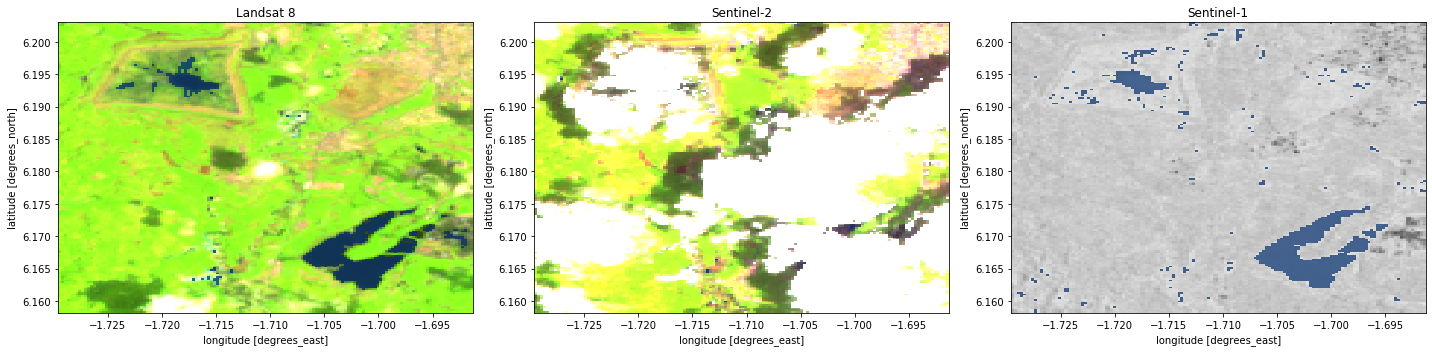

In [35]:
acquisition_time_index = 0

fig, ax = plt.subplots(1,3, figsize=(20, 5))
ls8_data.isel(time=acquisition_time_index)[['swir1','nir','red']].to_array().plot.imshow(ax=ax[0], vmin=0, vmax=3000)
ls8_water.isel(time=acquisition_time_index).where(ls8_water.isel(time=acquisition_time_index) == 1, np.nan)\
    .plot.imshow(ax=ax[0], cmap=plt.cm.Blues, alpha=0.75, vmin=0, vmax=1, add_colorbar=False)
ax[0].set_title('Landsat 8')

s2_data.isel(time=acquisition_time_index)[['swir_1','nir_1','red']].to_array().plot.imshow(ax=ax[1], vmin=0, vmax=3000)
s2_water.isel(time=acquisition_time_index).where(s2_water.isel(time=acquisition_time_index) == 1, np.nan)\
    .plot.imshow(ax=ax[1], cmap=plt.cm.Blues, alpha=0.75, vmin=0, vmax=1, add_colorbar=False)
ax[1].set_title('Sentinel-2')

s1_data.isel(time=acquisition_time_index).vv.plot.imshow(ax=ax[2], cmap=plt.cm.Greys, add_colorbar=False)
s1_water.isel(time=acquisition_time_index).where(s1_water.isel(time=acquisition_time_index) == 1, np.nan)\
    .plot.imshow(ax=ax[2], cmap=plt.cm.Blues, alpha=0.75, vmin=0, vmax=1, add_colorbar=False)
ax[2].set_title('Sentinel-1')
plt.tight_layout()

**Obtain the intersected clean mask for the sensors**

In [36]:
intersected_clean_mask = xr.DataArray((ls8_clean_mask.values & 
                                      s1_clean_mask.values & 
                                      s2_clean_mask.values), 
                                      coords=ls8_clean_mask.coords, 
                                      dims=ls8_clean_mask.dims)

In [37]:
# # Discard dates with excessive NaNs.
# agg_dims = ['latitude', 'longitude', 'variable']
# sufficient_data_mask = (not_nan_da.sum(agg_dims) / 
#                         not_nan_da.count(agg_dims)) > MIN_FRAC_DATA
# ls8_data = ls8_data.sel(time=sufficient_data_mask)

**Show the data and water classifications for each sensor - masked with the intersected clean mask**

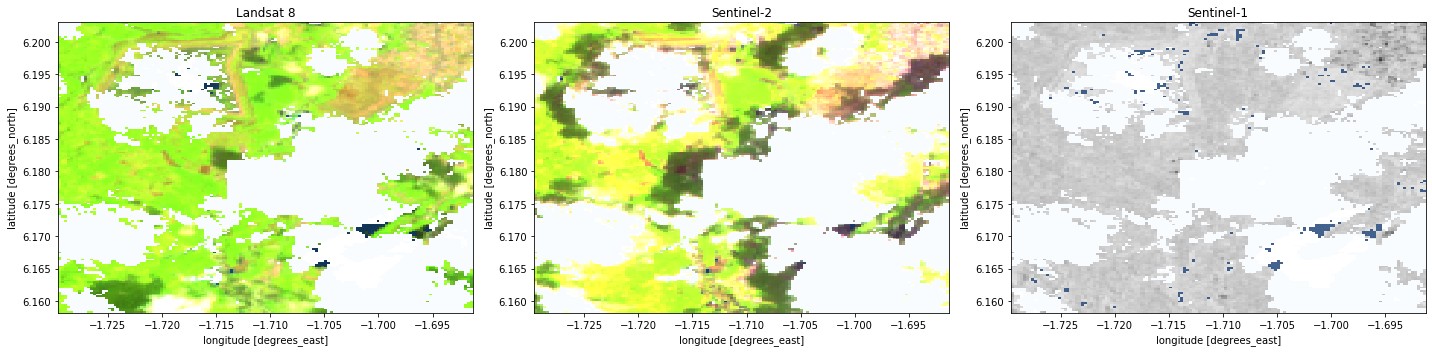

In [38]:
# acquisition_time_index = 0

fig, ax = plt.subplots(1,3, figsize=(20, 5))
ls8_data.isel(time=acquisition_time_index)[['swir1','nir','red']]\
    .where(intersected_clean_mask.isel(time=acquisition_time_index)).to_array().plot.imshow(ax=ax[0], vmin=0, vmax=3000)
ls8_water.isel(time=acquisition_time_index)\
    .where((ls8_water.isel(time=acquisition_time_index) == 1 & intersected_clean_mask.isel(time=acquisition_time_index)), np.nan)\
    .plot.imshow(ax=ax[0], cmap=plt.cm.Blues, alpha=0.75, vmin=0, vmax=1, add_colorbar=False)
ax[0].set_title('Landsat 8')

s2_data.isel(time=acquisition_time_index)[['swir_1','nir_1','red']]\
    .where(intersected_clean_mask.isel(time=acquisition_time_index)).to_array().plot.imshow(ax=ax[1], vmin=0, vmax=3000)
s2_water.isel(time=acquisition_time_index)\
    .where((s2_water.isel(time=acquisition_time_index) == 1 & intersected_clean_mask.isel(time=acquisition_time_index)), np.nan)\
    .plot.imshow(ax=ax[1], cmap=plt.cm.Blues, alpha=0.75, vmin=0, vmax=1, add_colorbar=False)
ax[1].set_title('Sentinel-2')

s1_data.isel(time=acquisition_time_index)\
    .where(intersected_clean_mask.isel(time=acquisition_time_index)).vv.plot.imshow(ax=ax[2], cmap=plt.cm.Greys, add_colorbar=False)
s1_water.isel(time=acquisition_time_index)\
    .where((s1_water.isel(time=acquisition_time_index) == 1 & intersected_clean_mask.isel(time=acquisition_time_index)), np.nan)\
    .plot.imshow(ax=ax[2], cmap=plt.cm.Blues, alpha=0.75, vmin=0, vmax=1, add_colorbar=False)
ax[2].set_title('Sentinel-1')
plt.tight_layout()

## Show the per-time-slice similarity (% of matching pixels) of each pair of sensors as a line plot

### Acquire water classifications for each dataset.

In [42]:
match = []
for time in range(ls8_water.time.size):
    match.append((ls8_water.isel(time=time).where(intersected_clean_mask, 0).astype(bool)\
                  & s2_water.isel(time=time).where(intersected_clean_mask, 0).astype(bool)\
                  & s1_water.isel(time=time).where(intersected_clean_mask, 0).astype(bool))\
                 .sum()/ls8_water.where(intersected_clean_mask, 0).isel(time=time).size*100)

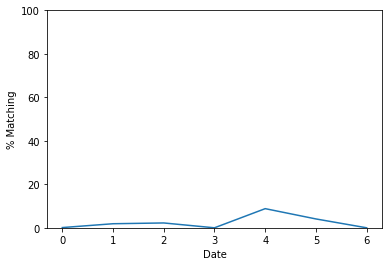

In [43]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(match)), list(map(lambda x: x.item(), match)))
ax.set_ylim(top=100, bottom=0)
ax.set_ylabel('% Matching')
ax.set_xlabel('Date');

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [41]:
display_map(x=(longitude-buffer, longitude+buffer), y=(latitude+buffer, latitude-buffer))

NameError: name 'buffer' is not defined

## Load and view Sentinel-1 data

The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest.
Since there is no time range provided, all available data will be selected.

**Please be patient**.
The data may take a few minutes to load.
The load is complete when the cell status goes from `[*]` to `[number]`.

In [ ]:
query = {
    'x': (longitude-buffer, longitude+buffer),
    'y': (latitude+buffer, latitude-buffer),
    'time':time,
}

# Load the data
ds_s1 = dc.load(**query, product="sentinel1_ghana_monthly")

**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `latitude` and `longitude` dimensions.

In [ ]:
print(ds_s1)

### Visualise loaded data

Sentinel-1 backscatter data has two measurements, *VV* and *VH*, which correspond to the polarisation of the light sent and received by the satellite.
*VV* refers to the satellite sending out vertically-polarised light and receiving vertically-polarised light back, whereas *VH* refers to the satellite sending out vertically-polarised light and receiving horizontally-polarised light back.
These two measurement bands can tell us different information about the area we're studying. 


#### Visualise VH band

In [ ]:
# Plot all VH observations for the year
ds_s1.vh.plot(cmap="Greys_r", robust=True, col="time", col_wrap=7)
plt.show()

In [ ]:
# Plot the average of all VH observations
mean_vh = ds_s1.vh.mean(dim="time")

fig = plt.figure(figsize=(7, 9))
mean_vh.plot(cmap="Greys_r", robust=True)
plt.title("Average VH")
plt.show()

What key differences do you notice between each individual observation and the mean?

#### Visualise VV band

In [ ]:
# Plot all VV observations for the year
ds_s1.vv.plot(cmap="Greys_r", robust=True, col="time", col_wrap=7)
plt.show()

In [ ]:
# Plot the average of all VV observations
mean_vv = ds_s1.vv.mean(dim="time")

fig = plt.figure(figsize=(7, 9))
mean_vv.plot(cmap="Greys_r", robust=True)
plt.title("Average VV")
plt.show()

What key differences do you notice between each individual observation and the mean? What about differences between the average *VH* and *VV* bands?

Take a look back at the map image to remind yourself of the shape of the land and water of our study area. In both bands, what distinguishes the land and the water?

## Preprocessing the data through filtering

### Speckle Filtering using Lee Filter

You may have noticed that the water in the individual *VV* and *VH* images isn't a consistent colour.
The distortion you're seeing is a type of noise known as speckle, which gives the images a grainy appearence.
If we want to be able to easily decide whether any particular pixel is water or land, we need to reduce the chance of misinterpreting a water pixel as a land pixel due to the noise.

Speckle can be removed through filtering.
If interested, you can find a technical introduction to speckle filtering [here](https://earth.esa.int/documents/653194/656796/Speckle_Filtering.pdf).
For now, it is enough to know that we can filter the data using the Python function defined in the next cell:

In [ ]:
# Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

Now that we've defined the filter, we can run it on the *VV* and *VH* data.
You might have noticed that the function takes a `size` argument.
This will change how blurred the image becomes after smoothing.
We've picked a default value for this analysis, but you can experiement with this if you're interested.

In [ ]:
# Set any null values to 0 before applying the filter to prevent issues
ds_s1_filled = ds_s1.where(~ds_s1.isnull(), 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
ds_s1["filtered_vv"] = ds_s1_filled.vv.groupby("time").apply(lee_filter, size=7)
ds_s1["filtered_vh"] = ds_s1_filled.vh.groupby("time").apply(lee_filter, size=7)


### Visualise filtered data

We can now visualise the filtered bands in the same way as the original bands.
Note that the filtered values must also be converted to decibels before being displayed.

#### Visualise filtered VH band

In [ ]:
# Plot all filtered VH observations for the year
ds_s1.filtered_vh.plot(cmap="Greys_r", robust=True, col="time", col_wrap=7)
plt.show()

In [ ]:
# Plot the average of all filtered VH observations
mean_filtered_vh = ds_s1.filtered_vh.mean(dim="time")

fig = plt.figure(figsize=(7, 9))
mean_filtered_vh.plot(cmap="Greys_r", robust=True)
plt.title("Average filtered VH")
plt.show()

#### Visualise filtered VV band

In [ ]:
# Plot all filtered VV observations for the year
ds_s1.filtered_vv.plot(cmap="Greys_r", robust=True, col="time", col_wrap=7)
plt.show()

In [ ]:
# Plot the average of all filtered VV observations
mean_filtered_vv = ds_s1.filtered_vv.mean(dim="time")

fig = plt.figure(figsize=(7, 9))
mean_filtered_vv.plot(cmap="Greys_r", robust=True)
plt.title("Average filtered VV")
plt.show()

Now that you've finished filtering the data, compare the plots before and after and you should be able to notice the impact of the filtering.
If you're having trouble spotting it, it's more noticable in the VH band. 

### Plotting VH and VV histograms

Another way to observe the impact of filtering is to view histograms of the pixel values before and after filtering.
Try running the next two cells to view the histograms for *VH* and *VV*.

In [ ]:
fig = plt.figure(figsize=(15, 3))
ds_s1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
ds_s1.vh.plot.hist(bins=1000, label="VH", alpha=0.5)
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Comparison of filtered VH bands to original")
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 3))
ds_s1.filtered_vv.plot.hist(bins=1000, label="VV filtered")
ds_s1.vv.plot.hist(bins=1000, label="VV", alpha=0.5)
plt.legend()
plt.xlabel("VV (dB)")
plt.title("Comparison of filtered VV bands to original")
plt.show()

You may have noticed that both the original and filtered bands show two peaks in the histogram, which we can classify as a bimodal distribution.
Looking back at the band images, it's clear that the water pixels generally have lower *VH* and *VV* values than the land pixels.
This lets us conclude that the lower distribution corresponds to water pixels and the higher distribution corresponds to land pixels.
Importantly, the act of filtering has made it clear that the two distributions can be separated, which is especially obvious in the *VH* histogram.
This allows us to confidently say that pixel values below a certain threshold are water, and pixel values above it are land.
This will form the basis for our classifier in the next section.

## Designing a threshold-based water classifier

Given that the distinction between the `land` and `water` pixel value distributions is strongest in the *VH* band, we'll base our classifier on this distribution.
To separate them, we can choose a threshold: pixels with values below the threshold are water, and pixels with values above the threshold are not water (land).

There are a number of ways to determine the threshold; one is to estimate it by looking at the *VH* histogram.
From this, we might guess that $\text{threshold} = -22.0$ is a reasonable value.
Run the cell below to set the threshold.

In [ ]:
threshold = -22.0

The classifier separates data into two classes: data above the threshold and data below the threshold.
In doing this, we assume that values of both segments correspond to the same `water` and `not water` distinctions we make visually.
This can be represented with a step function:

$$  \text{water}(VH) = \left\{
     \begin{array}{lr}
       \text{True} & :   VH < \text{threshold}\\
       \text{False} & :  VH \geq \text{threshold}
     \end{array}
   \right.\\ $$  

<br>


### Visualise threshold

To check if our chosen threshold reasonably divides the two distributions, we can add the threshold to the histogram plots we made earlier.
Run the next two cells to view two different visualisations of this.

In [ ]:
fig = plt.figure(figsize=(15, 3))
plt.axvline(x=threshold, label=f"Threshold at {threshold}", color="red")
ds_s1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
ds_s1.vh.plot.hist(bins=1000, label="VH", alpha=0.5)
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Histogram Comparison of filtered VH bands to original")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3))
ds_s1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
ax.axvspan(xmin=-30.0, xmax=threshold, alpha=0.25, color="green", label="Water")
ax.axvspan(xmin=threshold,
           xmax=-5,
           alpha=0.25,
           color="red",
           label="Not Water")
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Effect of the classifier")
plt.show()

If you're curious about how changing the threshold impacts the classifier, try changing the threshold value and running the previous two cells again.

## Build and apply the classifier

Now that we know the threshold, we can write a function to only return the pixels that are classified as water. The basic steps that the function will perform are:

1. Check that the data set has a *VH* band to classify.
2. Clean the data by applying the speckle filter.
3. Convert the *VH* band measurements from digital number (DN) to decibels (dB)
4. Find all pixels that have filtered values lower than the threshold; these are the `water` pixels.
5. Return a data set containing the `water` pixels.

These steps correspond to the actions taken in the function below.
See if you can determine which parts of the function map to each step before you continue.

In [ ]:
def s1_water_classifier(ds, threshold=-22.0):
    filtered = ds.vh.groupby("time").apply(lee_filter, size=7)
    water_data_array = filtered < threshold
    return water_data_array.to_dataset(name="s1_water")

Now that we have defined the classifier function, we can apply it to the data.
After you run the classifier, you'll be able to view the classified data product by running `print(ds_s1.water)`.

In [ ]:
ds_s1["water"] = s1_water_classifier(ds_s1).s1_water

In [ ]:
print(ds_s1.water)

### Assessment with mean

We can now view the image with our classification.
The classifier returns either `True` or `False` for each pixel.
To detect the shoreline, we want to check which pixels are always water and which are always land.
Conveniently, Python encodes `True = 1` and `False = 0`.
If we plot the average classified pixel value, pixels that are always water will have an average value of `1` and pixels that are always land will have an average of `0`.
Pixels that are sometimes water and sometimes land will have an average between these values.

The following cell plots the average classified pixel value over time.
How might you classify the shoreline from the average classification value?

In [ ]:
# Plot the mean of each classified pixel value
plt.figure(figsize=(15, 12))
ds_s1.water.mean(dim="time").plot(cmap="RdBu")
plt.title("Average classified pixel value")
plt.show()

#### Interpreting the mean classification 

You can see that our threshold has done a good job of separating the water pixels (in blue) and land pixels (in red). 

You should be able to see that the shoreline takes on a mix of values between `0` and `1`, highlighting pixels that are sometimes land and sometimes water.
This is likely to due the effect of rising and falling tides, with some radar observations being captured at low tide, and others at high tide. 



### Assessment with standard deviation

Given that we've identified the shoreline as the pixels that are classified sometimes as land and sometimes as water, we can also see if the standard deviation of each pixel in time is a reasonable way to determine if a pixel is shoreline or not.
Similar to how we calculated and plotted the mean above, you can calculate and plot the standard deviation by using the `std` function in place of the `mean` function.

If you'd like to see the results using a different colour-scheme, you can also try substituting `cmap="Greys"` or `cmap="Blues"` in place of `cmap="viridis"`.

In [ ]:
# Plot the standard deviation of each classified pixel value
plt.figure(figsize=(15, 12))
ds_s1.water.std(dim="time").plot(cmap="viridis")
plt.title("Standard deviation of classified pixel values")
plt.show()

#### Interpreting the standard deviation of the classification

From the image above, you should be able to see that the land and water pixels almost always have a standard deviation of `0`, meaning they didn't change over the time we sampled.
Areas along the coastline however have a higher standard deviation, indicating that they change frequently between water and non-water (potentially due to the rise and fall of the tide). 
With further investigation, you could potentially turn this statistic into a new classifier to extract shoreline pixels.
If you're after a challenge, have a think about how you might approach this.

An important thing to recognise is that the standard deviation might not be able to detect the difference between noise, tides and ongoing change, since a pixel that frequently alternates between land and water (noise) could have the same standard deviation as a pixel that is land for some time, then becomes water for the remaining time (ongoing change or tides).
Consider how you might distinguish between these different cases with the data and tools you have.

## Detecting change between two images

The standard deviation we calculated before gives us an idea of how variable a pixel has been over the entire period of time that we looked at.
It might also be interesting to look at which pixels have changed between any two particular times in our sample.

In the next cell, we choose the images to compare.
Printing the dataset should show you that there are 27 time-steps, so the first has an index value of `0`, and the last has an index value of `26`.
You can change these to be any numbers in between, as long as the start is earlier than the end.

In [ ]:
start_time_index = 0
end_time_index = 33

Next, we can define the change as the difference in the classified pixel value at each point.
Land becoming water will have a value of `-1` and water becoming land will have a value of `1`.

In [ ]:
change = np.subtract(ds_s1.water.isel(time=start_time_index),
                     ds_s1.water.isel(time=end_time_index),
                     dtype=np.float32)

# Set all '0' entries to NaN, which prevents them from displaying in the plot.
change = change.where(change != 0)
ds_s1["change"] = change

Now that we've added change to the dataset, you should be able to plot it below to look at which pixels changed. 
You can also plot the original mean *VH* composite to see how well the change matches our understanding of the shoreline location.


In [ ]:
plt.figure(figsize=(15, 12))
ds_s1.filtered_vh.mean(dim="time").plot(cmap="Blues")
ds_s1.change.plot(cmap="RdBu", levels=2)
plt.title(f"Change in pixel value between time={start_time_index} and time={end_time_index}")
plt.show()

### Coastal change or tides?

Tides can greatly affect the appearance of the coastline, particularly where tidal ranges are large.
Without additional data, it is difficult to determine whether the change above is due to the coastline having eroded over time, or because the two radar images were captured at different tides (e.g. low vs. high tide).
The radar water classifier in this notebook could potentially be combined with tidal modelling from the [Coastal Erosion notebook](Coastal_erosion.ipynb) to look into this question in more detail.

## Drawing conclusions
Here are some questions to think about:

* What are the benefits and drawbacks of the possible classification options we explored?
* How could you extend the analysis to extract a shape for the coastline?
* How reliable is our classifier?
* Is there anything you can think of that would improve it?

## Next steps
When you are done, return to the "Analysis parameters" section, modify some values (e.g. `latitude` and `longitude`) and rerun the analysis.
You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

If you're going to change the location, you'll need to make sure Sentinel-1 data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/ga_ls8c_gm_2_annual).

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** January 2019

**Compatible `datacube` version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index]()